## Imports

In [33]:
''' Data manipulation '''
import numpy as np
import pandas as pd
import statsmodels as st

''' Data visualization'''
import matplotlib.pyplot as plt
import seaborn as sns

# 🚀 Imóveis - Estimador Avançado  

❗️ O mercado percebeu que, se tivermos mais apartamentos do que características em nosso conjunto de dados ($\large n$ observações $\large> p$ características), não conseguimos "resolver" a equação $\large \boldsymbol X \cdot \boldsymbol \theta = \boldsymbol y $. Sem uma fórmula determinística para $\large \boldsymbol \theta$, não seríamos mais capazes de prever os preços de novos apartamentos!  

----

🎯 Neste exercício, agora temos acesso a um conjunto de dados maior, contendo 1000 apartamentos, e queremos refinar nossa previsão para o mesmo apartamento de antes:  

- `Área`: 3000 $ft^2$  
- `Quartos`: 5  
- `Andares`: 1  

❌ Em vez de resolver $\large \boldsymbol X \cdot \boldsymbol \theta = \boldsymbol y $ com uma matriz $\large \boldsymbol X$ de dimensão $ (1000,4)$ que é **`não invertível`**...  

🚀 ...encontraremos um $\large {\boldsymbol \theta} = \begin{bmatrix}  
     \theta_0 \\  
     \theta_1 \\  
     \theta_2 \\  
     \theta_3  
\end{bmatrix}_{4 \times 1}$ que minimiza o erro $ \large \boldsymbol e = \boldsymbol X \cdot \hat{\boldsymbol \theta} - \boldsymbol y  $; essa abordagem é chamada de **`Modelo de Regressão Linear`**. Mediremos esse erro $\boldsymbol e$ usando a distância euclidiana $\large \left\|\boldsymbol e\right\|$ e o **`Erro Quadrático Médio.`**  

👉 Vamos calcular $\large \hat{\boldsymbol \theta}$ para encontrar uma estimativa aproximada do preço do novo apartamento.

## (1) Exploração de Dados  

Carregamos o conjunto de dados `flats.csv` abaixo.

In [9]:
flats = pd.read_csv('flats.csv')
flats.head(10)

,price,bedrooms,surface,floors
0,274.0,3,1830,2.0
1,500.0,4,2120,1.0
2,320.0,3,1260,1.0
3,445.5,3,1880,1.0
4,637.5,3,1680,1.0
5,460.0,2,2730,1.0
6,259.0,3,1270,1.5
7,950.0,3,2780,1.0
8,550.0,3,1930,2.0
9,265.5,3,1860,1.0


👀 Use `gráficos de dispersão` para visualizar e identificar <u><i>qual característica fornece mais informações sobre os preços:</i></u>

<Axes: xlabel='floors', ylabel='price'>

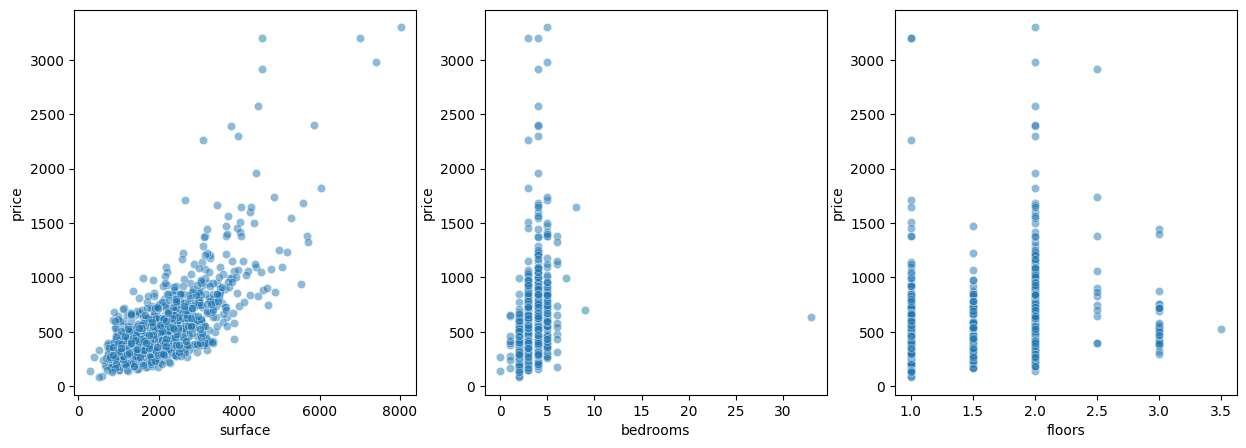

In [10]:
# Your plots here
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

sns.scatterplot(x= 'surface', y='price', data=flats, alpha=0.5, ax=ax1)
sns.scatterplot(x= 'bedrooms', y='price', data=flats, alpha=0.5, ax=ax2)
sns.scatterplot(x= 'floors', y='price', data=flats, alpha=0.5, ax=ax3)

👉 Parece que `área` é um indicador mais forte do preço do que o número de quartos ou andares. Em estatística, dizemos que o `preço` está mais **correlacionado** com `área` do que com outras características.  

👉 Vamos verificar isso rodando [`pandas.DataFrame.corr`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.corr.html) abaixo, que calcula os coeficientes de correlação entre cada par de colunas do DataFrame.  

<i><u>Valores importantes:</u></i>  
* 1 significa que as duas colunas estão perfeitamente correlacionadas 📈  
* -1 significa que as duas colunas estão perfeitamente inversamente correlacionadas 📉  
* 0 significa que as duas colunas não estão *linearmente* correlacionadas 😐  

<details>
    <summary><i>Por que usamos o coeficiente de correlação e não o coeficiente de covariância?</i></summary>

✅ <u>Semelhanças</u>:  
    
- 📈 Correlações positivas e covariâncias positivas entre duas variáveis X e Y significam a mesma coisa: quando X aumenta, Y aumenta, e vice-versa.  
- 📉 Correlações negativas e covariâncias negativas entre duas variáveis X e Y significam a mesma coisa: quando X aumenta, Y diminui, e vice-versa.  
- 🤔 Uma correlação nula e uma covariância nula entre duas variáveis X e Y significam a mesma coisa:  
    - Elas não estão _linearmente correlacionadas_, ou seja, não existe uma relação do tipo $ Y = aX + b$  
    - No entanto, ainda podem ter outro tipo de relação, como $Y = X^{2}$ (relação quadrática), $Y = e^{X}$ (relação exponencial), $Y = ln(X)$ (relação logarítmica), $Y = sin(\sqrt{1+X^7})$ (relação não convencional), etc.  

❗️<u>Principais diferenças</u>:  

- 😖 A covariância entre duas variáveis X e Y pode ser infinitamente positiva ou infinitamente negativa: $ cov(X, Y) \in ( - \infty ; + \infty ) $  
    Exemplo: se $ cov (X, Y) = 10 $ e $ cov (X, Z) = 30 $, você pode dizer que X e Z são "mais correlacionados"? _Não_, pois não é possível comparar grandezas diferentes diretamente.  

    🧑🏻‍🏫 Como resolver esse problema? Usamos a correlação, frequentemente denotada pela letra grega $\rho$ (pronuncia-se "rhô").  

👉 <u>Consequência</u>:  

- Podemos ver a correlação como uma _covariância padronizada_, simplesmente dividindo a covariância pelo desvio padrão de $X$ e pelo desvio padrão de $Y$:  
$$ \large  \rho(X,Y) = \frac{cov(X,Y)}{\sigma_X \sigma_Y} \in [0;1]$$  

Continuando com o exemplo: suponha agora que $ \rho(X, Y) = 0.80 $ e $ \rho(X, Z) = 0.15 $, você ainda diria que X e Z são mais correlacionados? Não; na verdade, X e Y são mais correlacionados do que X e Z!  
</details>

In [11]:
flats.corr()

,price,bedrooms,surface,floors
price,1.000000,0.239623,0.732790,0.258263
bedrooms,0.239623,1.000000,0.417170,0.131993
surface,0.732790,0.417170,1.000000,0.357512
floors,0.258263,0.131993,0.357512,1.000000


🎨 Para uma visualização rápida dessa matriz, você pode usar um **heatmap** da função [`seaborn.heatmap`](https://seaborn.pydata.org/generated/seaborn.heatmap.html).  

<details>
    <summary><i>Dicas adicionais para exibir uma matriz de correlação mais legível</i></summary>

- `cmap`: Como o **Seaborn** é uma biblioteca de visualização construída sobre o **Matplotlib**, você pode usar o argumento [`cmap`](https://matplotlib.org/stable/tutorials/colors/colormaps.html), que representa o _mapa de cores_.  
- `annot`: Para facilitar a leitura das correlações, você pode exibir os coeficientes diretamente no heatmap colorido.  
- `annot_kws`: Permite personalizar a aparência dos coeficientes de correlação exibidos.  
</details>

<Axes: >

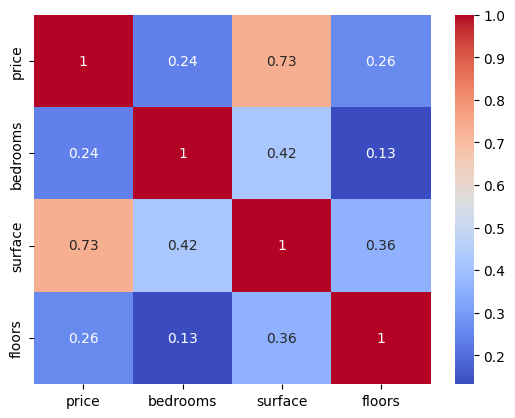

In [12]:
sns.heatmap(
    flats.corr(),
    cmap = "coolwarm", 
    annot = True,
    annot_kws = {'fontsize':10}
)

## (2) Estimador com 1 Característica  

Vamos tentar construir um estimador estatístico do **preço** como uma função de apenas uma característica: a **área**.  

🎯 Nosso objetivo é ajustar uma **regressão linear** entre essas duas variáveis.  

Na prática, queremos escolher os melhores parâmetros $\hat{\boldsymbol \theta}$ = (`inclinação`, `intercepto`) de forma que a `previsão de preço = inclinação * área + intercepto` seja o mais próxima possível do `preço real`, em termos de Erro Quadrático Médio (MSE).  

📅 Nas próximas semanas, exploraremos e estudaremos diferentes modelos (Regressão Linear, KNN, Regressão Logística, Redes Neurais, etc.).  

👉 Uma parte essencial do seu trabalho será escolher o modelo correto e otimizar os parâmetros para obter as melhores previsões.

### (2.1) Visual Approach

❓Implemente a função `plot_line(slope, intercept)`.  

Dado os argumentos `inclinação` e `intercepto`, essa função deve criar um array `preco_previsto` e traçar essa linha sobre os dados originais (gráfico de dispersão).  

Depois de codificar a função, experimente diferentes valores de `(inclinação, intercepto)` até encontrar uma “boa aproximação linear” dos dados. Você consegue encontrar o melhor ajuste?  

Guia visual:  

<img src="https://wagon-public-datasets.s3.amazonaws.com/03-Maths/01-Algebra-Calculus/line_of_best_fit.png" width=400>

In [13]:
def plot_line(data, slope, intercept):
    # First, we'll create x - an array of our independent variable values - for you.
    x = data['surface']

    # Now create an array of predicted prices using the predicted prices formula above
    # Remember, we can do mathematical operations on an entire array at once!
    y_pred = None
    # $DELETE_BEGIN
    y_pred = x * slope + intercept
    # $DELETE_END

    # Finally, let's plot the line!
    plt.plot(x, y_pred);

Teste sua função executando a célula abaixo e, em seguida, altere os valores para ver se consegue aproximar uma boa linha de melhor ajuste!  

*Dica: você pode rodar `plot_line()` várias vezes na mesma célula para obter várias linhas sobre o mesmo gráfico de dispersão* 😉

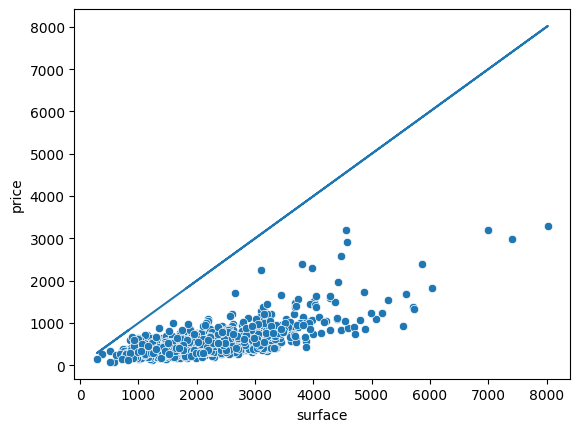

In [14]:
sns.scatterplot(x="surface", y="price", data=flats)
plot_line(flats, 1, 1)

😅 Não é tão fácil (e nem muito “científico”), certo?

### (2.2) Abordagem Computacional  

🔥 Para garantir que nossa linha estimadora seja a melhor possível, precisamos calcular o **Erro Quadrático Médio (MSE)** entre os **preços reais** e os **preços previstos**!  

👉 Lembre-se de que:  
- Para cada apartamento, `preco_previsto = inclinação * área + intercepto`  
- Tanto o **vetor de preços reais** quanto o **vetor de preços previstos** têm dimensão $ (1000, 1)$  

#### (2.2.1) Erros Quadráticos

<u><b>Passo 1</b></u>  

❓Para cada linha (_ou seja, cada apartamento_), devemos calcular o `erro_quadrático = (preco - preco_previsto)**2`❓

In [15]:
def compute_squared_errors(slope, intercept, surfaces, prices):
    """
    TODO: return an array containing the squared errors between 
    all real prices from the dataset and the predicted prices
    """
    # $CHALLENGIFY_BEGIN
    return (prices - ((slope * surfaces) + intercept)) ** 2
    # $CHALLENGIFY_END

💡 Um princípio geral em Ciência de Dados/Modelagem é que $ \large erro = f(\boldsymbol y, \hat{\boldsymbol y})$, onde:  

- $ \large \boldsymbol y $ é o valor real  
- $ \large \hat{\boldsymbol y} $ é o valor previsto  
- $ \large f$ é frequentemente chamada de **Função de Perda** ou **Função de Custo**  
    - 📆 Veja `Machine Learning I > Ajuste de Modelo`  

#### (2.2.2) Erro Quadrático Médio (MSE)

<u><b>Passo 2</b></u>  

❓ Crie a função `mse`, que deve retornar a média do array retornado pela função `squared_errors`. ❓

In [16]:
def compute_mse(slope, intercept, surfaces, prices):
    '''TODO: Return the mean of the array contained in squared_errors as a float.'''
    # $CHALLENGIFY_BEGIN
    errors = compute_squared_errors(slope, intercept, surfaces, prices)

    return np.mean(errors)
    # $CHALLENGIFY_END

👉 Na seção _(2.1) Abordagem visual_, você tentou estimar visualmente a "melhor linha", que consiste em encontrar o melhor par `(inclinação, intercepto)`.  

❓Usando esse "melhor par", calcule o MSE do seu estimador. ❓

In [19]:
compute_mse(0.271, -30, flats.surface, flats.price)

np.float64(58527.43021436)

### (2.3) Encontrando os Melhores Parâmetros  

👉 Continue testando diferentes valores para `inclinação` e `intercepto` e tente obter o melhor ajuste manualmente! Perceba como é difícil otimizar ambos os parâmetros ao mesmo tempo.  

👇 Siga os passos abaixo para ter uma ideia de uma possível abordagem:

#### (2.3.1) Encontrando a Melhor Inclinação

**<u>Passo 1:</u>**  

Comece fixando um `intercepto_inicial` com sua melhor estimativa e, em seguida, encontre uma inclinação que minimize aproximadamente a função `mse = f(inclinação)`.

In [22]:
# Define an initial_intercept, for instance, we may suppose there is always a small transaction fee even for very small flats
# $DELETE_BEGIN
initial_intercept = 30
# $DELETE_END

In [21]:
# Create a range of 100 slopes that contains what you believe is the optimal slope (hint: np.linspace())
# $DELETE_BEGIN
slope_range = np.linspace(0,0.7,100)
# $DELETE_END

In [23]:
# Create the list of MSEs for each slope value
# $DELETE_BEGIN
mses = list(map(lambda x: compute_mse(x, initial_intercept, flats.surface, flats.price), slope_range))
# $DELETE_END

❓Trace um gráfico de MSEs em função das inclinações. Você consegue identificar um mínimo❓  

🙃 Se não conseguir, tente outro intervalo de valores para as inclinações!

Text(0, 0.5, 'MSE')

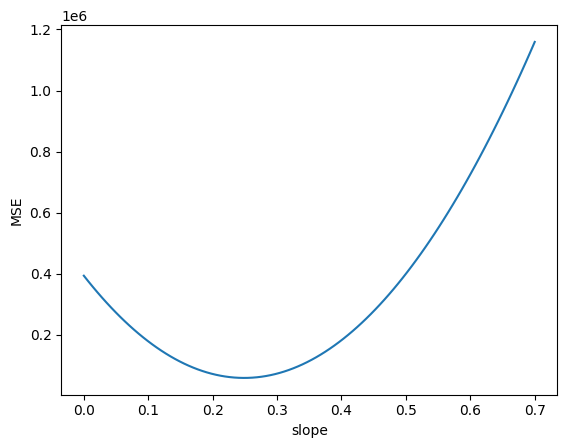

In [24]:
plt.plot(slope_range, mses)
plt.xlabel("slope")
plt.ylabel("MSE")

❓Calcule o valor mínimo do MSE para o seu `intercepto_inicial` e o correspondente `melhor_inclinação` (`slope_best`)❓  

<details>  
    <summary><i>Dica</i></summary>  
    
Aqui, você pode usar a função embutida `.min()` do Python, assim como o método `List.index()`.  

</details>

In [25]:
mse_min = min(mses)
slope_best = slope_range[mses.index(mse_min)]

print('mse_min:', mse_min)
print('slope_best:', slope_best)

mse_min: 59197.19095882538
slope_best: 0.24747474747474746


#### (2.3.2) Encontrando o Melhor Intercepto

**<u>Passo 2:</u>**  

🔨 Agora, vamos fixar a inclinação no valor `melhor_inclinação` (`slope_best`) e, em seguida, reutilizar a abordagem anterior para encontrar o `melhor_intercepto` (`intercept_best`).

In [26]:
# Create a range of 100 intercepts that contains what you believe is the optimal intercept
# $DELETE_BEGIN
intercept_range = np.linspace(-50, 50, 100)
# $DELETE_END

In [27]:
# Create the list of MSEs for each intercept value
# $DELETE_BEGIN
mses = list(map(lambda x: compute_mse(slope_best, x, flats.surface, flats.price), intercept_range))
# $DELETE_END

Text(0, 0.5, 'MSE')

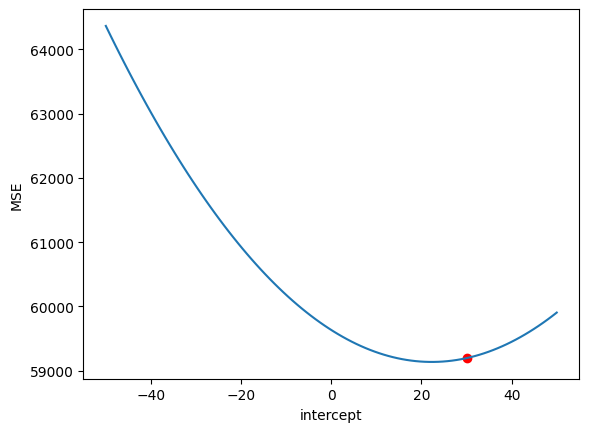

In [28]:
# Plot MSEs against intercepts. Do you see a minimum? If not, try another range of slopes!
# $DELETE_BEGIN
plt.plot(intercept_range, mses)
plt.scatter(initial_intercept, compute_mse(slope_best, initial_intercept, flats.surface, flats.price), color = 'r')
plt.xlabel('intercept')
plt.ylabel("MSE")
# $DELETE_END

❓Calcule `mse_min`, o valor mínimo dos MSEs quando a inclinação for igual a `melhor_inclinação` (`slope_best`), e armazene o intercepto correspondente como `melhor_intercepto` (`intercept_best`).❓

In [29]:
mse_min = None
intercept_best = None

In [30]:
mse_min = min(mses)
intercept_best = intercept_range[mses.index(mse_min)]

print('mse_min:', mse_min)
print('intercept_best:', intercept_best)

mse_min: 59137.948260276244
intercept_best: 22.727272727272734


🎉 **Ótimo trabalho**! Ao adicionar um parâmetro de intercepto diferente de zero, conseguimos reduzir ainda mais o MSE (sinta-se à vontade para traçar a linha de regressão sobre o gráfico de dispersão para confirmar visualmente o ajuste aproximado).  

❓No entanto, o que garante que esses parâmetros (`melhor_intercepto`, `melhor_inclinação`) são realmente os melhores?

<details>  
    <summary>👀 Explicação</summary>  

Talvez possamos encontrar um valor de inclinação ainda melhor repetindo o passo ①, desta vez fixando o intercepto em `melhor_intercepto`, e depois repetir o passo ② com a nova inclinação para ajustar novamente o intercepto.  

Para encontrar o mínimo global de uma função com dois parâmetros `rmse = f(inclinação, intercepto)`, pode ser necessário repetir os passos ① e ② indefinidamente até que os valores converjam para mínimos absolutos – sem garantia de sucesso.  

<img src='https://wagon-public-datasets.s3.amazonaws.com/data-science-images/decision-science/real-estate-minimizer.png'>  

💪 Você acaba de descobrir um dos aspectos mais fundamentais do Machine Learning: **o processo iterativo de busca por mínimos**.  

👉 Como você pode imaginar, no mundo da Ciência de Dados, foram desenvolvidos algoritmos para automatizar e otimizar esses processos. Nas próximas semanas, você descobrirá o poder de outros algoritmos, como **Descida do Gradiente**, e bibliotecas Python como `Statsmodels`, que realizam esse processo iterativo para você.  

</details>

👉 Execute as células abaixo se estiver curioso e quiser encontrar a melhor inclinação e intercepto para este conjunto de dados, calculados usando **Descida do Gradiente** (📆 abordado em **Machine Learning I > Under The Hood**).

<Axes: xlabel='surface', ylabel='price'>

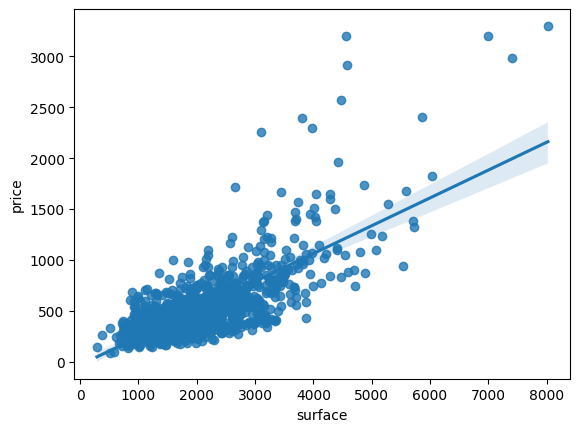

In [31]:
# Try this out (Seaborn visual solution)
sns.regplot(data=flats, x='surface', y='price')

In [34]:
# Try this out (statsmodels, exact solution)!
import statsmodels.formula.api as smf

regression = smf.ols(formula= 'price ~ surface', data=flats).fit()

print("intercept_best", regression.params['Intercept'])
print("slope_best", regression.params['surface'])
print('mse_best: ', np.mean(regression.resid**2))

intercept_best -33.30833598535581
slope_best 0.27369043218689093
mse_best:  58515.12390949639


❓Vamos voltar à nossa pergunta inicial: qual é sua nova previsão para o 5º apartamento abaixo? Como ela se compara com sua previsão inicial baseada em apenas 4 apartamentos?  

- `área`: 3000 $ft^2$  
- `quartos`: 5  
- `andares`: 1  

In [35]:
# compute predicted price (Remember that the real price is 750,000$)
# $CHALLENGIFY_BEGIN
print('predicted price: ', regression.params['surface'] * 3000 + regression.params['Intercept'])
# $CHALLENGIFY_END

predicted price:  787.7629605753169


☝️ Essa previsão é melhor do que nosso estimador determinístico inicial, que considerava apenas 4 apartamentos. No entanto, ainda estamos ignorando as informações fornecidas pelo número de quartos e andares nessa previsão!

## (3) Estimador com _Todas_ as Características (`área`, `quartos`, `andares`)?

💡 Uma regressão linear com três características (**Regressão Linear Multivariada**) funciona da mesma forma que com uma única característica, mas, em vez de determinar apenas 2 parâmetros para minimizar o RMSE (`intercepto` e `inclinação`), precisaremos encontrar 4 parâmetros:  
$\hat{\boldsymbol \theta}$ = (`intercepto`, `inclinação_área`, `inclinação_quartos`, `inclinação_andares`).  

🗓 Haverá uma aula totalmente dedicada à **Regressão Linear Multivariada** no módulo **Ciência da Decisão**.  

🗓 O mesmo método iterativo de **Descida do Gradiente** pode ser aplicado, e você mesmo irá implementá-lo manualmente mais adiante no bootcamp.  

👉 Enquanto isso, sinta-se à vontade para rodar a célula abaixo e visualizar o resultado final dessa regressão multivariada.

In [36]:
# Find the four regression coefficients by running this cell
regression = smf.ols(formula= 'price ~ surface + bedrooms + floors', data=flats).fit()
regression.params

Intercept    18.154854
surface       0.286953
bedrooms    -21.623564
floors       -3.811868
dtype: float64

🎉 Agora que encontramos os melhores parâmetros  

$$\boldsymbol {\hat \theta}= \begin{bmatrix}  
     \theta_0 \\  
     \theta_1 \\  
     \theta_2 \\  
     \theta_3 \\  
\end{bmatrix}_{4 \times 1} =  
\begin{bmatrix}  
     \theta_{intercepto} \\  
     \theta_{área} \\  
     \theta_{quartos} \\  
     \theta_{andares}  
\end{bmatrix}_{4 \times 1} =  
\begin{bmatrix}  
    18.154854 \\  
    0.286953 \\  
    -21.623564 \\  
    -3.811868  
\end{bmatrix}_{4 \times 1}  
$$  

podemos prever o preço do novo apartamento com:  

* **Área**: $3000 ft^2$  
* **Quartos**: $5$  
* **Localizado no** $1º$ **andar**  

$$ \hat{y_5} = \theta_0 + \theta_1 \times 3000 + \theta_2 \times 5 + \theta_3 \times 1 $$

In [37]:
# Compute the newly predicted price for the 5th flat? Is this prediction better?
# $CHALLENGIFY_BEGIN
regression.params['Intercept'] +\
regression.params['surface']*3000 +\
regression.params['bedrooms']*5 +\
regression.params['floors']*1
# $CHALLENGIFY_END

np.float64(767.085107310286)

## (4) Considerações Finais sobre Álgebra Linear 🧠

Este **problema de otimização** pode ser resumido da seguinte forma:  

- Precisamos encontrar um vetor de parâmetros  
$$\hat{\boldsymbol \theta} = \begin{bmatrix}  
     \theta_{intercepto} \\  
     \theta_{área} \\  
     \theta_{quartos} \\  
     \theta_{andares}  
\end{bmatrix}_{4 \times 1}$$  

- Que minimize o erro  
$$ e = \left\|\boldsymbol X\cdot \hat{\boldsymbol \theta} - \boldsymbol y  \right\|^2 $$  

- Para uma matriz de características $\boldsymbol X$ [constante, área, andares, quartos]  
$$
\begin{bmatrix}  
    1 & 620 & 1 & 1 \\  
    1 & 3280 & 4 & 2 \\  
    ... \\  
    1 & 1900 & 2 & 2 \\  
    1 & 1320 & 3 & 3  
\end{bmatrix}_{n \times 4}
$$  

- e um vetor de observações  
$$\boldsymbol y  = \begin{bmatrix}  
           y_{1} \\  
           y_{2} \\  
           \vdots \\  
           y_{1000}  
\end{bmatrix}$$ (preços).  

Esse $\large \hat{\theta}$ é encontrado quando as "derivadas" de $\boldsymbol e$, ou seja,  
$$ \large 2 \boldsymbol X^T\cdot (\boldsymbol X \cdot \hat{\theta}−\boldsymbol y )$$  
são iguais a zero (👉 prova durante o módulo de Ciência da Decisão).  

Em outras palavras, precisamos resolver o sistema linear  
$$\large (\boldsymbol X^T\cdot \boldsymbol X)\cdot \hat{\boldsymbol \theta}=\boldsymbol X^T \cdot \boldsymbol y $$  

Este sistema linear tem uma solução única desde que nenhuma coluna de $\boldsymbol X$ possa ser expressa como uma combinação linear das outras. Nesse caso, a matriz  
$$ \large (\boldsymbol X^T \cdot \boldsymbol X)^{-1}$$  
é invertível, e o mínimo é alcançado quando  
$$\large \hat{\boldsymbol \theta} = (\boldsymbol X^T\cdot \boldsymbol X)^{-1} \cdot \boldsymbol X^T \cdot \boldsymbol y $$  

Note que $\boldsymbol X$ não precisa mais ser quadrada, ao contrário do primeiro desafio 💪.  

💥 No entanto, lembre-se de que **inverter matrizes é computacionalmente complexo**. Por isso, foram desenvolvidos outros métodos para encontrar o mínimo de uma função, como **Descida do Gradiente**.  

📚 Leia mais sobre isso no [Stats.StackExchange](https://stats.stackexchange.com/a/278779) se tiver interesse!